In [ ]:
!pip install --upgrade "qiskit[all]" qiskit-nature qiskit-aer
!pip install "qiskit<2" pyscf

/tmp/ipykernel_154318/4057900108.py:31: DeprecationWarning: The class ``qiskit.primitives.backend_estimator.BackendEstimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendEstimator` class is `BackendEstimatorV2`.
  estimator = BackendEstimator(


Step   1:  E = -4.84450571
Step   2:  E = -4.56800704
Step   3:  E = -4.81491243
Step   4:  E = -4.90441290
Step   5:  E = -4.89477446
Step   6:  E = -4.77688732
Step   7:  E = -5.27949641
Step   8:  E = -5.34157231
Step   9:  E = -5.12299517
Step  10:  E = -4.84674466
Step  11:  E = -5.10100268
Step  12:  E = -4.98379686
Step  13:  E = -4.83413407
Step  14:  E = -4.95840224
Step  15:  E = -5.39458921
Step  16:  E = -5.29035785
Step  17:  E = -4.76713860
Step  18:  E = -5.24882406
Step  19:  E = -5.47770285
Step  20:  E = -5.69561105
Step  21:  E = -5.71734889
Step  22:  E = -6.21233849
Step  23:  E = -6.48783377
Step  24:  E = -5.72561747
Step  25:  E = -6.64158758
Step  26:  E = -6.01669254
Step  27:  E = -6.17160773
Step  28:  E = -5.29726689
Step  29:  E = -6.50979966
Step  30:  E = -6.60980777
Step  31:  E = -6.64488833
Step  32:  E = -6.50464115
Step  33:  E = -6.46655642
Step  34:  E = -6.66899147
Step  35:  E = -6.62791620
Step  36:  E = -6.65793078
Step  37:  E = -6.60075767
S

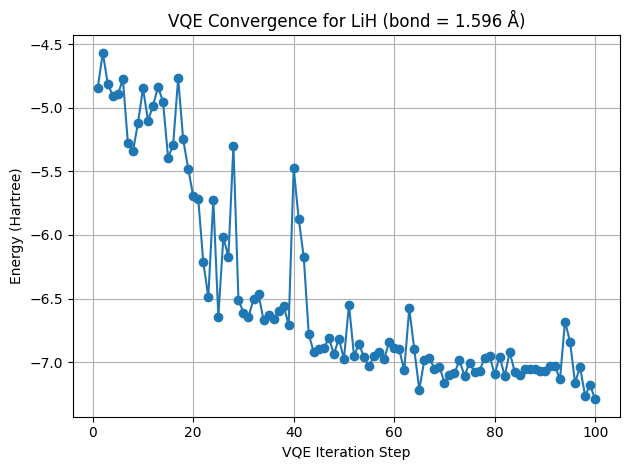

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock

from qiskit_aer import AerSimulator
from qiskit.primitives import BackendEstimator
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import COBYLA

# 1. Build problem
bond = 1.596
xyz = f"Li 0 0 0; H 0 0 {bond}"
driver = PySCFDriver(atom=xyz, basis="sto3g", unit=DistanceUnit.ANGSTROM)
problem = driver.run()
ferm_op = problem.hamiltonian.second_q_op()

mapper = JordanWignerMapper()
qubit_H = mapper.map(ferm_op)

# 2. Ansatz
hf = HartreeFock(problem.num_spatial_orbitals, problem.num_particles, mapper)
ansatz = UCCSD(problem.num_spatial_orbitals, problem.num_particles, mapper)
ansatz.initial_state = hf

# 3. Estimator backend
backend = AerSimulator(method="statevector")
estimator = BackendEstimator(
    backend=backend,
    options={
        "shots": None,
        "grouping": "pauli",
        "max_evals_grouped": 10,
    },
)

# Energy tracking
energy_trace = []

def vqe_callback(eval_count: int, parameters: np.ndarray, mean: float, metadata: dict):
    energy_trace.append(mean)
    stddev = metadata.get("stddev", None)
    print(f"Step {eval_count:>3}:  E = {mean:.8f}")
    if stddev is not None:
        print(f"         stddev = {stddev:.8f} Ha")

# 4. Run VQE
optimizer = COBYLA(maxiter=100, tol=1e-6)
vqe = VQE(estimator, ansatz, optimizer, callback=vqe_callback)

result = vqe.compute_minimum_eigenvalue(qubit_H)

# 5. Print energy
E_elec = result.eigenvalue.real
E_nuc = problem.hamiltonian.constants["nuclear_repulsion_energy"]
print("Electronic  :", E_elec)
print("Nuclear rep.:", E_nuc)
print("Total       :", E_elec + E_nuc)

# 6. Plot convergence
plt.plot(range(1, len(energy_trace) + 1), energy_trace, marker='o')
plt.xlabel("VQE Iteration Step")
plt.ylabel("Energy (Hartree)")
plt.title("VQE Convergence for LiH (bond = 1.596 Å)")
plt.grid(True)
plt.tight_layout()
plt.show()